# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [5]:
data.columns

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

## 1. What test is appropriate for this problem? Does CLT apply?

This is a very large dataset with 4870 samples.  As the research article states, 4 resumes were sent for each job opening.  I would assume that each applicant can be treated as independent as it would be possible for there to be multiple callbacks for the same job opening (i.e. if one applicant got a callback, the others wouldn't be automatically rejected).  Therefore, the CLT would apply.  The values I will be looking at are the proportion of white sounding applicants that had callbacks and the proportion of black sounding applicants that had callbacks.  I will compare these proportions using a two proportion z-test.  Also, hypothesis testing with permutation/bootstrap samples will be done.  

## 2. What are the null and alternate hypotheses?

Null Hypothesis: The proportion of callbacks for white sounding applicants is the same as that for black sounding applicants (Pw = Pb).    
Alternate Hypothesis: The proportion of callbacks for white sounding applicants is not the same as that for black sounding applicants (Pw != Pb).  

## 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

### Permutation Approach (p-value)

In [7]:
# Defining functions
def frac_callback(white, black):
    """computes the fraction of applicants with black sounding names that got callbacks"""
    frac = np.sum(black) / len(black)
    return frac

def permutation_sample(data1, data2):
    """generates a permutation sample from 2 datasets"""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data1):]
    return perm_sample1, perm_sample2

def draw_perm_reps(data1, data2, func, size=1):
    """generates multiple permutation replicates"""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample1, perm_sample2 = permutation_sample(data1, data2)
        perm_replicates[i] = func(perm_sample1, perm_sample2)
    return perm_replicates
    

In [8]:
# Calculating how many callbacks there were for each group
white = data[data.race=='w'] # applicants with white sounding names
black = data[data.race=='b'] # applicants with black sounding names

white_call = int(sum(data[data.race=='w'].call)) # number of applicants with white sounding names that received callbacks
white_nocall = len(white) - white_call      # number of applicants with white sounding names that did not receive callbacks

black_call = int(sum(data[data.race=='b'].call)) # number of applicants with black sounding names that received callbacks
black_nocall = len(black) - black_call      # number of applicants with black sounding names that did not receive callbacks

print('There were ' + str(white_call) + ' applicants that received callbacks out of ' + str(len(white)) + ' applicants with white sounding names (' + str(round((white_call * 100)/len(white), 2)) + '%).')
print('There were ' + str(black_call) + ' applicants that received callbacks out of ' + str(len(black)) + ' applicants with black sounding names (' + str(round((black_call * 100)/len(black), 2)) + '%).')

There were 235 applicants that received callbacks out of 2435 applicants with white sounding names (9.65%).
There were 157 applicants that received callbacks out of 2435 applicants with black sounding names (6.45%).


In [9]:
# Constructing arrays of data
w = np.array([True] * white_call + [False] * white_nocall)  # array for applicants with white sounding names
b = np.array([True] * black_call + [False] * black_nocall)  # array for applicants with black sounding names

In [10]:
# Getting permutation samples
perm_replicates = draw_perm_reps(w, b, frac_callback, 10000)

# Compute p-value
p = np.sum(perm_replicates <= 157/2435) / len(perm_replicates)  # finding replicates that are less than or equal to the actual proportion of applicants with black sounding names that got callbacks
print('p-value: ' + str(p))

p-value: 0.0


### Bootstrap Approach

In [11]:
# Defining function
def draw_bs_replicates(data, size=1):
    """draws bootstraps replicates, calculating the fraction of callbacks"""
    inds = np.arange(len(data))
    yes_prop = np.empty(size)
    
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_data = data.iloc[bs_inds, :]
        bs_yes = sum(bs_data.call)
        yes_prop[i] = (bs_yes / len(bs_data))
        
        #bs_white, bs_black = white.iloc[bs_inds, :], black.iloc[bs_inds, :]
        #w_yes = sum(bs_white[bs_white.race=='w'].call)
        #white_yes[i] = (w_yes / len(bs_white))
        #b_yes = sum(bs_black[bs_black.race=='b'].call)
        #black_yes[i] = (b_yes / len(bs_black))
    
    return yes_prop

In [12]:
white = data[data.race=='w'] # applicants with white sounding names
black = data[data.race=='b'] # applicants with black sounding names

# Drawing bootstrap replicates and getting the fraction of callbacks 
white_yes = draw_bs_replicates(white, 10000)
black_yes = draw_bs_replicates(black, 10000)

In [13]:
# Getting the 95% confidence interval for the difference in the fraction of callbacks
diff = white_yes - black_yes
conf_lower, conf_upper = np.percentile(diff, [2.5, 97.5])
print('The 95% confidence interval is from ' + str(round(conf_lower, 3)) + ' to ' + str(round(conf_upper, 3)) + ' (difference in proportion of callbacks between white/black sounding applicants)')

The 95% confidence interval is from 0.017 to 0.047 (difference in proportion of callbacks between white/black sounding applicants)


In [14]:
# Getting the 95% confidence interval for the fraction of callbacks for white sounding applicants
conf_lower_w, conf_upper_w = np.percentile(white_yes, [2.5, 97.5])
print('The 95% confidence interval is from ' + str(round(conf_lower_w, 3)) + ' to ' + str(round(conf_upper_w, 3)) + ' (proportion of callbacks for white sounding applicants)')

The 95% confidence interval is from 0.085 to 0.108 (proportion of callbacks for white sounding applicants)


In [15]:
# Getting the 95% confidence interval for the fraction of callbacks for black sounding applicants
conf_lower_b, conf_upper_b = np.percentile(black_yes, [2.5, 97.5])
print('The 95% confidence interval is from ' + str(round(conf_lower_b, 3)) + ' to ' + str(round(conf_upper_b, 3)) + ' (proportion of callbacks for black sounding applicants)')

The 95% confidence interval is from 0.055 to 0.074 (proportion of callbacks for black sounding applicants)


In [16]:
# Drawing bootstrap replicates and getting the fraction of callbacks. 
# Both white and black drawing from the full dataset with no regard to race. 
white_yes_null = draw_bs_replicates(data, 10000)
black_yes_null = draw_bs_replicates(data, 10000)

In [17]:
diff_obs = white_call / len(white) - black_call / len(black)  # difference in proportions of callbacks in observed data
diff_null = white_yes_null - black_yes_null # difference in proportions of callbacks in null replicates data

# Calculating p-value
p_value = np.sum(diff_null >= diff_obs) / len(diff)  # finding null replicates that are more than or equal to the observed difference in proportions of callbacks
print('p-value: ' + str(p_value))

p-value: 0.0


### Frequentist Statistical Approach 

In [18]:
# Using the z-test to compare the proportions of callbacks to the number of white/black sounding applicants
# The equation used is:  z = (p1 - p2) / sqrt(p(1-p) * (1/n1 + 1/n2)) where p = (Y1 + Y2) / (n1 + n2)  
# p1 is the proportion of white sounding applicants with callbacks 
# p1 is the proportion of white sounding applicants with callbacks 
# Y1 is the number of white sounding applicants with callbacks
# Y2 is the number of black sounding applicants with callbacks
# n1 is the total number of white sounding applicants
# n2 is the total number of black sounding applicants

white = data[data.race=='w'] # applicants with white sounding names
black = data[data.race=='b'] # applicants with black sounding names

white_call = int(sum(data[data.race=='w'].call)) # number of applicants with white sounding names that received callbacks
black_call = int(sum(data[data.race=='b'].call)) # number of applicants with black sounding names that received callbacks

n1 = len(white)
n2 = len(black)

Y1 = white_call
Y2 = black_call

p1 = Y1 / n1 
p2 = Y2 / n2

p = (Y1 + Y2) / (n1 + n2)

z_stat = (p1 - p2) / np.sqrt(p * (1-p) * (1/n1 + 1/n2))

p_value = stats.norm.sf(abs(z_stat)) * 2  # two sided p-value
print('z-statistic: ' + str(z_stat) + '\np-value: '+ str(p_value))

z-statistic: 4.108412152434346
p-value: 3.983886837585077e-05


In [19]:
# Checking the z-statistic and p-value with proportions_ztest
z_stat, p_value = proportions_ztest(count = [white_call, black_call], nobs = [len(white), len(black)], value = 0)
print('z-statistic: ' + str(z_stat) + '\np-value: '+ str(p_value))

z-statistic: 4.108412152434346
p-value: 3.983886837585077e-05


In [20]:
# Calculating the margin of error and 95% confidence interval for the difference in proportion of callbacks (white - black)
# Standard error is: sqrt((p1*(1-p1))/n1 + (p2*(1-p2)/n2))
# p1 is the proportion of white sounding applicants with callbacks 
# p1 is the proportion of white sounding applicants with callbacks 
# n1 is the total number of white sounding applicants
# n2 is the total number of black sounding applicants

p1 = white_call / len(white) 
p2 = black_call / len(black)

n1 = len(white)
n2 = len(black)

obs_diff = p1 - p2

std_error = np.sqrt((p1 * (1-p1)) / n1 + (p2 * (1-p2) / n2))
marg_error = 1.96 * std_error  # 1.96 is the critical value for 95% confidence level
conf_lower_z = obs_diff - marg_error
conf_upper_z = obs_diff + marg_error
print('The 95% confidence interval is from ' + str(round(conf_lower_z, 3)) + ' to ' + str(round(conf_upper_z, 3)) + ' (difference in proportion of callbacks between white/black sounding applicants)')

The 95% confidence interval is from 0.017 to 0.047 (difference in proportion of callbacks between white/black sounding applicants)


## 4. Write a story describing the statistical significance in the context or the original problem.

|        | # Applicants |  # Callbacks | % Callback |
| ------------- | ------------- | ------------- | 
| White Sounding  | 2435  | 235 | 9.65% |
| Black Sounding  | 2435  | 157 | 6.45% |

The above table shows that for the observed data, the percentage of callbacks was greater for applicants with white sounding names.  

As a reminder, my null hypothesis was the proportion of callbacks for white sounding applicants is the same as that for black sounding applicants.

In the permutation approach, the p-value was 0.  This means that after shuffling and resampling the data 10000 times, while assuming the null hypothesis was true, the calculated proportions of callbacks for black sounding applicants was never equal to or less than what was observed (0.065).  This led me to reject the null hypothesis. 

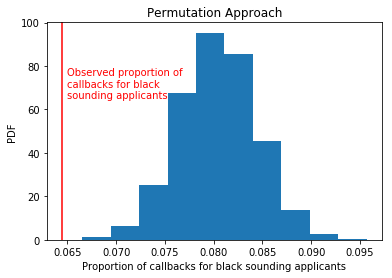

In [21]:
# Plotting PDF of the proportion of applicants with black sounding names that received callbacks
_ = plt.hist(perm_replicates, density = 1)
_ = plt.axvline(x = 157/2435, color = 'r')
_ = plt.text(0.065, 65, 'Observed proportion of \ncallbacks for black \nsounding applicants', color = 'r')
_ = plt.xlabel('Proportion of callbacks for black sounding applicants')
_ = plt.ylabel('PDF')
_ = plt.title('Permutation Approach')

In the bootstrap approach, the p-value was also 0.  This means that after resampling the data 10000 times, while assuming the null hypothesis was true, the calculated difference in proportions of callbacks for white and black sounding applicants was never equal to or greater than what was observed (0.032).  This again led me to reject the null hypothesis. 

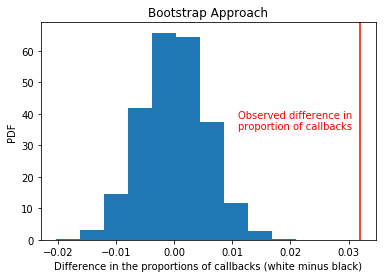

In [22]:
# Plotting PDF of the difference in the proportions of null data and the observed difference in proportion of callbacks
_ = plt.hist(diff_null, density = 1)
_ = plt.axvline(x = diff_obs, color = 'r')
_ = plt.text(0.011, 35, 'Observed difference in \nproportion of callbacks', color = 'r')
_ = plt.xlabel('Difference in the proportions of callbacks (white minus black)')
_ = plt.ylabel('PDF')
_ = plt.title('Bootstrap Approach')

Using the proportions z-test, the z-statistic was 4.11 and the p-value was 3.98 * 10^-5.  The large z-statistic indicates there is a difference in the proportions of callbacks for black and white sounding applicants.  As the calculated p-value is two sided, the significance level of 0.025 is considered (0.05 divided by 2).  The p-value is much smaller than the significance level so I would reject the null hypothesis.  Therefore, there indeed is a significant difference in the proportion of callbacks for white sounding applicants and that for black sounding applicants.  

Using the bootstrap approach, the following 95% confidence intervals were generated: 

|  | 95% Confidence Interval |
|---------|----------------|
| Difference in proportion of callbacks (white minus black) | 0.017 to 0.047      |
| Proportion of callbacks for white sounding applicants | 0.085 to 0.108 |
| Proportion of callbacks for black sounding applicants | 0.055 to 0.074 |

The confidence intervals for the proportion of callbacks for white and black sounding applicants do not overlap. In addition, the below figure shows that the distributions of the resampled data barely overlap.  This supports the alternative hypothesis that there is a significant difference in the two proportions. 

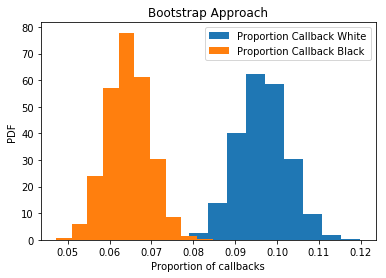

In [23]:
# Plotting PDF of the proportion of applicants that received callbacks (bootstrap)
_ = plt.hist(white_yes, density = 1)
_ = plt.hist(black_yes, density = 1)
_ = plt.legend(('Proportion Callback White', 'Proportion Callback Black'), loc = 'upper right')
_ = plt.xlabel('Proportion of callbacks')
_ = plt.ylabel('PDF')
_ = plt.title('Bootstrap Approach')

## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

In [24]:
# Grouping data by race and computing the percent of callbacks
data_race = data.pivot_table(index = 'race', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_race['Percent Callbacks'] = round(data_race[1.0] * 100 / data_race['All'], 2)

# Grouping data by sex and computing the percent of callbacks
data_sex = data.pivot_table(index = 'sex', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_sex['Percent Callbacks'] = round(data_sex[1.0] * 100 / data_sex['All'], 2)

# Grouping data by military and computing the percent of callbacks
data_military = data.pivot_table(index = 'military', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_military['Percent Callbacks'] = round(data_military[1.0] * 100 / data_military['All'], 2)

# Grouping data by number of jobs of the applicant and computing the percent of callbacks
data_jobs = data.pivot_table(index = 'ofjobs', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_jobs['Percent Callbacks'] = round(data_jobs[1.0] * 100 / data_jobs['All'], 2)

# Grouping data by computer skills and computing the percent of callbacks 
data_computer = data.pivot_table(index = 'computerskills', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_computer['Percent Callbacks'] = round(data_computer[1.0] * 100 / data_computer['All'], 2)

# Grouping data by special skills and computing the percent of callbacks
data_skills = data.pivot_table(index = 'specialskills', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_skills['Percent Callbacks'] = round(data_skills[1.0] * 100 / data_skills['All'], 2)

# Grouping data by city and computing the percent of callbacks
data_city = data.pivot_table(index = 'city', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_city['Percent Callbacks'] = round(data_city[1.0] * 100 / data_city['All'], 2)

# Grouping data by number of jobs of the applicant and computing the percent of callbacks
data_exp = data.pivot_table(index = 'yearsexp', columns = 'call', values = 'id', aggfunc = len, margins=True)
data_exp['Percent Callbacks'] = round(data_exp[1.0] * 100 / data_exp['All'], 2)

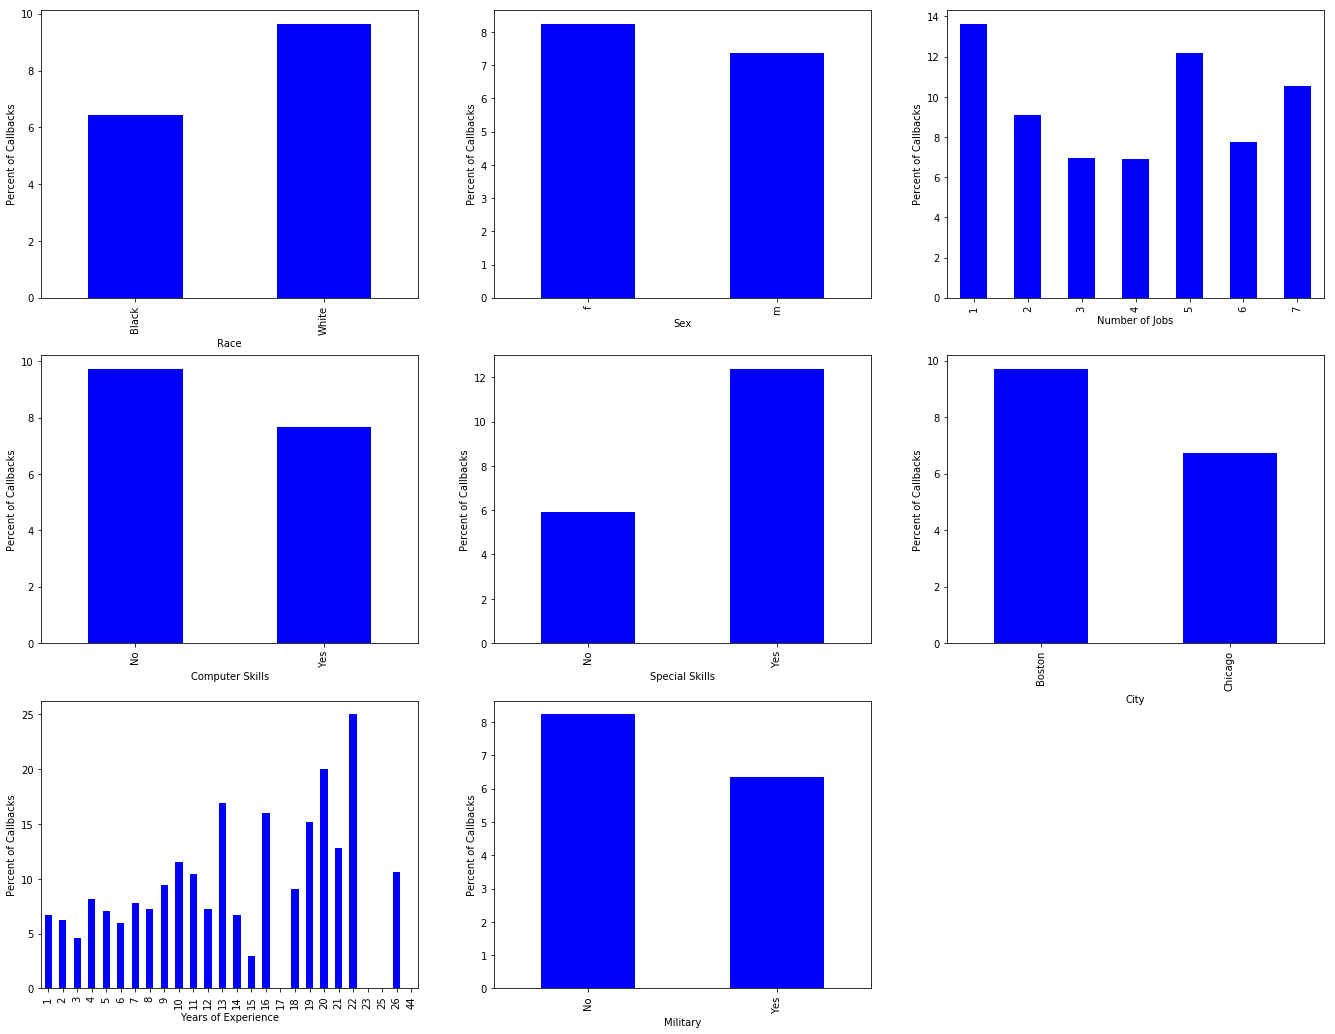

In [25]:
# Plotting figures

fig, axes = plt.subplots(3, 3, figsize = (23,18))

_ = data_race[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[0,0])
_ = axes[0,0].set_ylabel('Percent of Callbacks')
_ = axes[0,0].set_xlabel('Race')
_ = axes[0,0].set_xticklabels(('Black', 'White'))

_ = data_sex[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[0,1])
_ = axes[0,1].set_ylabel('Percent of Callbacks')
_ = axes[0,1].set_xlabel('Sex')

_ = data_military[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[2,1])
_ = axes[2,1].set_ylabel('Percent of Callbacks')
_ = axes[2,1].set_xlabel('Military')
_ = axes[2,1].set_xticklabels(('No', 'Yes'))

_ = data_jobs[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[0,2])
_ = axes[0,2].set_ylabel('Percent of Callbacks')
_ = axes[0,2].set_xlabel('Number of Jobs')

_ = data_computer[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[1,0])
_ = ax=axes[1,0].set_ylabel('Percent of Callbacks')
_ = ax=axes[1,0].set_xlabel('Computer Skills')
_ = ax=axes[1,0].set_xticklabels(('No', 'Yes'))

_ = data_skills[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[1,1])
_ = axes[1,1].set_ylabel('Percent of Callbacks')
_ = axes[1,1].set_xlabel('Special Skills')
_ = axes[1,1].set_xticklabels(('No', 'Yes'))

_ = data_city[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[1,2])
_ = axes[1,2].set_ylabel('Percent of Callbacks')
_ = axes[1,2].set_xlabel('City')
_ = axes[1,2].set_xticklabels(('Boston', 'Chicago'))

_ = data_exp[:-1]['Percent Callbacks'].plot.bar(color='blue', ax=axes[2,0])
_ = axes[2,0].set_ylabel('Percent of Callbacks')
_ = axes[2,0].set_xlabel('Years of Experience')

fig.delaxes(axes[2,2]) 

There are 62 other meaningful columns of data that we can examine in regards to if the applicant received a callback or not.  Analysis of these columns will need to be performed in order to see if race/name is the most important factor in callback success.  

Above are plots of some of the variables collected in this study and the percent of callbacks.  Applicants with white sounding names and those in Boston received a higher percentage of callbacks (by ~3%).  Applicants with no computer skills and those who were not in the military received a higher percentage of callbacks (by ~2%).  Female applicants actually received a higher percentage of callbacks then men, but this difference was smaller (~1%).  Applicants who had 1 job received a higher percentage of callbacks (by ~6%) than applicants who had 3, 4, and 6 jobs.  Applicants who had special skills received a higher percentage of callbacks (by ~6%).  Finally, applicants with 22 years of experience received a higher percentage of callbacks (~18%) than those with just 1 year of experience.  

From my above preliminary analysis above, it appears that race/name may not have been the most important factor in callback success.  